In [35]:
# ==========================================
# [AI vs Human(자기소개서) 분류 프로젝트]
# - KoBERT(backbone) freeze + Linear head 학습
# - Train/Valid로 best 저장 후, best로 Test 1회 평가
# ==========================================

In [36]:
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## 시각화
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [37]:
# =========================
# [0] Train / Valid / Test Split 
# =========================
from sklearn.model_selection import train_test_split
import os

ALL_PATH   = "./Data/all.csv"           ## 전체 데이터셋 경로
TRAIN_PATH = "./Data/train.csv"         ## Train 데이터 저장 경로
VALID_PATH = "./Data/valid.csv"         ## valid 데이터 저장 경로
TEST_PATH  = "./Data/test.csv"          ## test 데이터 저장 경로

RANDOM_STATE = 42   ## 랜덤 상수 지정               
VALID_SIZE = 0.1    ## train_valid_test = 8:1:1
TEST_SIZE  = 0.1


## 데이터셋 가져오기
df = pd.read_csv(ALL_PATH, encoding="utf-8-sig")


## text, label 컬럼만 가져오기
need_cols = {"text", "label"}
if not need_cols.issubset(df.columns):
    raise ValueError(f"all.csv에는 최소 {need_cols} 컬럼이 필요함. 현재: {df.columns}")

# 1차 split: train vs temp
train_df, temp_df = train_test_split(
    df,
    test_size=(VALID_SIZE + TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=df["label"]
)

# 2차 split: valid vs test
test_ratio = TEST_SIZE / (VALID_SIZE + TEST_SIZE)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=test_ratio,
    random_state=RANDOM_STATE,
    stratify=temp_df["label"]
)

## 분리 후 데이터셋 저장
train_df.to_csv(TRAIN_PATH, index=False, encoding="utf-8-sig")
valid_df.to_csv(VALID_PATH, index=False, encoding="utf-8-sig")
test_df.to_csv(TEST_PATH,  index=False, encoding="utf-8-sig")


print("Split complete")
print("[TRAIN]", len(train_df), train_df["label"].value_counts().to_dict())
print("[VALID]", len(valid_df), valid_df["label"].value_counts().to_dict())
print("[TEST ]", len(test_df),  test_df["label"].value_counts().to_dict())

Split complete
[TRAIN] 128 {1: 65, 0: 63}
[VALID] 16 {1: 8, 0: 8}
[TEST ] 17 {1: 9, 0: 8}


In [38]:
# =========================
# 1) Utils: Seed 고정 (재현성)
# =========================
## 재현성을 위한 시드 고정
def seed_everything(seed: int = 42) :
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [39]:
# =============================================================
# 2) Dataset: CSV -> 토크나이즈 -> 텐서 반환
# =============================================================
class ResumeAIDataset(Dataset):
    """
    KoBERT 분류용 Dataset
    - 입력 CSV: text, label 컬럼 필요
    - 출력: input_ids, attention_mask, labels
    """

    def __init__(self, csv_path, tokenizer, max_len = 256):
        
        
        ## 클래스 맴버 df 초기화
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.df = pd.read_csv(csv_path, encoding="utf-8-sig")
        
        # 필수 컬럼 체크 -> 없을 시 value에러 일으킴
        if "text" not in self.df.columns or "label" not in self.df.columns:
            raise ValueError(f"{csv_path}에는 'text', 'label' 컬럼이 필요합니다.")

        # 텍스트 최소 정리
        self.df["text"] = (
            self.df["text"]
            .astype(str)
            .str.replace("\ufeff", "") ## 엑셀 -> CSV 변환시 생기는 마크(BOM) 제거
            .str.strip() ## 앞뒤 공백 제거
        )

        # 빈 텍스트 제거
        self.df = self.df[self.df["text"] != ""].reset_index(drop=True)

        # label 정수화
        self.df["label"] = self.df["label"].astype(int)


    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> dict:
        text = self.df.loc[idx, "text"]
        label = int(self.df.loc[idx, "label"])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),            # (L,)
            "attention_mask": enc["attention_mask"].squeeze(0),  # (L,)
            "labels": torch.tensor(label, dtype=torch.long)      # ()
        }




In [40]:
# =========================
# 3) Model: KoBERT freeze + Linear head
# =========================
class KoBERTLinearHeadClassifier(nn.Module):
    """
    KoBERT : 한국어 문장을 "의미 좌표(768차원 벡터)"로 바꿔주는 거대한 뇌 언어
    BERT : 문장의 의미를 벡터로 압축하는 모델
    --> 이미 학습된 모델
    
    freeze의 의미 : KoBERT는 이미 학습되어 있으니 더이상 학습 X ==> 더이상 가중치 업데이터 X
    --> 학습 속도 증가, 과적합 저하, 적은 데이터에 적합
    
    KoBERT는 고정(freeze)하고 head(Linear)만 학습하는 분류기
    - forward 출력: logits (B, 2)
    """

    def __init__(self, pretrained_name = "skt/kobert-base-v1", num_labels = 2, dropout = 0.2):
        super().__init__()

        self.bert = BertModel.from_pretrained(pretrained_name)

        # backbone freeze : 학습 안하겠다. 
        for p in self.bert.parameters():
            p.requires_grad = False ## 가중치 업데이트 끄기

        hidden = self.bert.config.hidden_size   # 768
        self.dropout = nn.Dropout(dropout)      # 랜덤으로 20%를 0으로 만듦 -> 특정 신호의 의존 방어, train에만 적용, eval에는 off
        # self.classifier = nn.Linear(hidden, num_labels)   ## 선형 모델로
        # self.classifier = nn.Sequential(    ## 비선형 모델로
        #     nn.Linear(768, 512),
        #     nn.GELU(),
        #     nn.Dropout(0.3),

        #     nn.Linear(512, 256),
        #     nn.GELU(),
        #     nn.Dropout(0.3),

        #     nn.Linear(256, 128),
        #     nn.GELU(),
        #     nn.Dropout(0.3),

        #     nn.Linear(128, 2)
        # )
        
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )



    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]  # (B, 768) : [CLS]
        x = self.dropout(cls)
        logits = self.classifier(x)           # (B, 2)
        return logits




In [41]:
# =========================
# 4) Train / Evaluate
# =========================
def train_one_epoch(model: nn.Module,
                    loader: DataLoader,
                    optimizer: torch.optim.Optimizer,
                    criterion: nn.Module,
                    device: str) -> float:
    """1 epoch 학습"""
    model.train()
    total_loss = 0.0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(1, len(loader))


@torch.no_grad()
def evaluate(model: nn.Module,
             loader: DataLoader,
             device: str):
    """
    검증/테스트 평가
    - accuracy
    - macro F1 (데이터 적을 때/클래스 불균형에 비교적 안정)
    - confusion matrix
    """
    model.eval()
    y_true, y_pred = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1_macro, cm

@torch.no_grad()
def extract_cls_embeddings(model, loader, device):
    """
    KoBERT [CLS] 임베딩 추출
    return:
        embeddings: (N, 768)
        labels: (N,)
    """
    model.eval()
    embeddings = []
    labels = []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["labels"].numpy()

        outputs = model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_vec = outputs.last_hidden_state[:, 0, :]  # (B, 768)
        embeddings.append(cls_vec.cpu().numpy())
        labels.append(y)

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels




DEVICE: cuda


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1039.32it/s, Materializing param=pooler.dense.weight]                              


[Epoch 01] loss=0.7065 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[8 0]
 [8 0]]
[Epoch 02] loss=0.7128 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[0 8]
 [0 8]]
[Epoch 03] loss=0.7132 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[8 0]
 [8 0]]
[Epoch 04] loss=0.6953 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[0 8]
 [0 8]]
[Epoch 05] loss=0.7122 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[8 0]
 [8 0]]
[Epoch 06] loss=0.6838 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[0 8]
 [0 8]]
[Epoch 07] loss=0.7085 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[0 8]
 [0 8]]
[Epoch 08] loss=0.6966 | val_acc=0.5625 | val_f1_macro=0.4589
Confusion Matrix (VALID):
 [[1 7]
 [0 8]]
[Epoch 09] loss=0.6917 | val_acc=0.5000 | val_f1_macro=0.3333
Confusion Matrix (VALID):
 [[8 0]
 [8 0]]
[Epoch 10] loss=0.6978 | val_acc=0.5000 | val_f1_macro=0.3333
Co

C:\Users\kdt008\AppData\Local\Temp\ipykernel_22744\3578805025.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(SAVE_PATH, map_location=D

[TEST] acc=0.5882 | f1_macro=0.4711
Confusion Matrix (TEST):
 [[1 7]
 [0 9]]

📊 Visualizing KoBERT CLS embeddings...


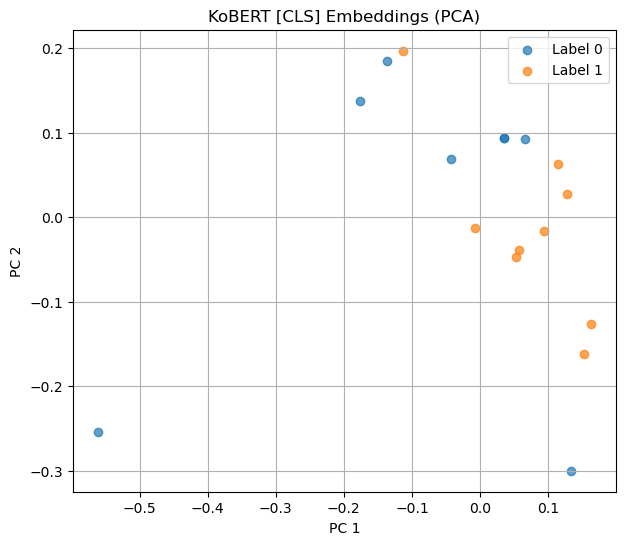

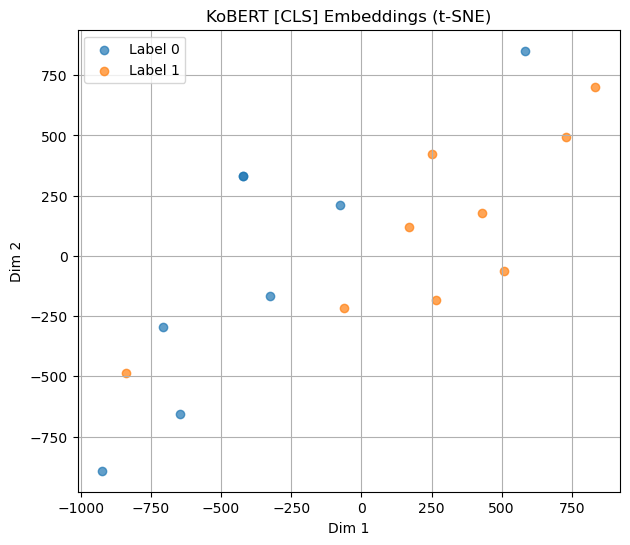

In [44]:
# =========================
# 5) Main: 설정 -> 데이터로더 -> 학습 -> best 저장 -> test 평가
# =========================
def main():
    # --- 재현성 ---
    seed_everything(42)

    # --- 환경/모델 설정 ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    PRETRAINED = "skt/kobert-base-v1"

    # --- 데이터 경로 ---
    TRAIN_PATH = "./Data/train.csv"
    VALID_PATH = "./Data/valid.csv"
    TEST_PATH  = "./Data/test.csv"

    # --- 하이퍼파라미터 ---
    MAX_LEN = 254
    BATCH_SIZE = 20
    EPOCHS = 20
    LR = 1e-3
    SAVE_PATH = "./best_head_only.pt"

    print("DEVICE:", DEVICE)

    # --- 토크나이저/데이터셋/로더 ---
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED)

    train_ds = ResumeAIDataset(TRAIN_PATH, tokenizer, max_len=MAX_LEN)
    valid_ds = ResumeAIDataset(VALID_PATH, tokenizer, max_len=MAX_LEN)
    test_ds  = ResumeAIDataset(TEST_PATH,  tokenizer, max_len=MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    # --- 모델/손실/옵티마이저 ---
    model = KoBERTLinearHeadClassifier(pretrained_name=PRETRAINED).to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    # head만 학습
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LR)

    # --- 학습 루프 (best는 valid macro F1 기준 저장) ---
    best_f1_macro = -1.0

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_acc, val_f1_macro, val_cm = evaluate(model, valid_loader, DEVICE)

        print(f"[Epoch {epoch:02d}] loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_f1_macro={val_f1_macro:.4f}")
        print("Confusion Matrix (VALID):\n", val_cm)

        if val_f1_macro > best_f1_macro:
            best_f1_macro = val_f1_macro
            torch.save(model.state_dict(), SAVE_PATH)

    print("\n✅ Best VALID F1_macro:", best_f1_macro)
    print("✅ Saved:", SAVE_PATH)

    # --- 테스트 평가는 best 모델로 1회 ---
    print("\n===== Load BEST model and Evaluate on TEST =====")
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))

    test_acc, test_f1_macro, test_cm = evaluate(model, test_loader, DEVICE)
    print(f"[TEST] acc={test_acc:.4f} | f1_macro={test_f1_macro:.4f}")
    print("Confusion Matrix (TEST):\n", test_cm)


    # =========================
    # 6) KoBERT 임베딩 시각화
    # =========================
    print("\n📊 Visualizing KoBERT CLS embeddings...")

    embeddings, labels = extract_cls_embeddings(model, test_loader, DEVICE)

    # ---------- PCA ----------
    pca = PCA(n_components=2, random_state=42)
    emb_pca = pca.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(
            emb_pca[idx, 0],
            emb_pca[idx, 1],
            label=f"Label {label}",
            alpha=0.7
        )

    plt.title("KoBERT [CLS] Embeddings (PCA)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- t-SNE ----------
    tsne = TSNE(
        n_components=2,
        perplexity=7,
        learning_rate=200,
        max_iter=1000,
        random_state=42
    )

    emb_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(7, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(
            emb_tsne[idx, 0],
            emb_tsne[idx, 1],
            label=f"Label {label}",
            alpha=0.7
        )

    plt.title("KoBERT [CLS] Embeddings (t-SNE)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
